In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings



## Ignoring Warnings

In [93]:
warnings.filterwarnings('ignore')

## Loading and Viewing Data

In [94]:
df = pd.read_csv('data/personal_finance_employees_V2.csv')
df.head()

,Employee,Monthly Income (£),Electricity Bill (£),Gas Bill (£),Netflix (£),Amazon Prime (£),Groceries (£),Transportation (£),Water Bill (£),Sky Sports (£),Other Expenses (£),Savings for Property (£),Monthly Outing (£)
0,Employee_1,4999.39,120.000000,80.0000,12.0,4.99,239.69000,149.11000,40.0,70.0,100.000000,300.0,120.0
1,Employee_2,4660.24,120.000000,80.0000,12.0,4.99,226.24000,197.23000,40.0,70.0,100.000000,300.0,120.0
2,Employee_3,1942.89,124.679456,98.1346,12.0,4.99,333.77745,201.27956,40.0,70.0,125.770693,0.0,120.0
3,Employee_4,3565.80,120.000000,80.0000,12.0,4.99,213.04000,154.67000,40.0,0.0,100.000000,300.0,120.0
4,Employee_5,5121.99,120.000000,80.0000,12.0,4.99,182.56000,190.71000,40.0,70.0,100.000000,300.0,0.0


## Calculating Financial Ratios

In [95]:
def analyze_employee_finances(df, employee_id): 
    employee = df[df['Employee'] == employee_id].iloc[0]
    
    # Calculate key metrics
    total_expenses = sum([
        employee['Electricity Bill (£)'],
        employee['Gas Bill (£)'],
        employee['Netflix (£)'],
        employee['Amazon Prime (£)'],
        employee['Groceries (£)'],
        employee['Transportation (£)'],
        employee['Water Bill (£)'],
        employee['Sky Sports (£)'] ,
        employee['Other Expenses (£)'] ,
        employee['Monthly Outing (£)'] 
    ])
    
    # Calculate percentages
    expenses_breakdown = {
        'Cost of living': (employee['Electricity Bill (£)'] + employee['Gas Bill (£)'] + 
                     (employee['Water Bill (£)'])),
        'Entertainment': (employee['Netflix (£)'] + employee['Amazon Prime (£)'] + 
                        (employee['Sky Sports (£)'] ) +
                        (employee['Monthly Outing (£)'])),
        'Essentials': employee['Groceries (£)'] + employee['Transportation (£)'],
        'Other': employee['Other Expenses (£)']
    }
    
    savings = employee['Savings for Property (£)'] if not np.isnan(employee['Savings for Property (£)']) else 0
    
    # Calculate financial ratios
    financial_health = {
        'Income': employee['Monthly Income (£)'],
        'Total Expenses': total_expenses,
        'Savings': savings,
        'Disposable Income': employee['Monthly Income (£)'] - total_expenses - savings,
        'Savings Rate': (savings / employee['Monthly Income (£)']) * 100 if savings > 0 else 0,
        'Expense Ratio': (total_expenses / employee['Monthly Income (£)']) * 100,
        'Essential Expenses Ratio': ((expenses_breakdown['Cost of living'] + expenses_breakdown['Essentials']) / 
                                   employee['Monthly Income (£)']) * 100
    }
    return financial_health, expenses_breakdown

personal_dashboard = analyze_employee_finances(df, 'Employee_4')
print(f"Financial Dashboard for Employee 4: {personal_dashboard}")

Financial Dashboard for Employee 4: ({'Income': 3565.8, 'Total Expenses': 844.6999999999999, 'Savings': 300.0, 'Disposable Income': 2421.1000000000004, 'Savings Rate': 8.413259296651523, 'Expense Ratio': 23.688933759605135, 'Essential Expenses Ratio': 17.042739357226992}, {'Cost of living': 240.0, 'Entertainment': 136.99, 'Essentials': 367.71, 'Other': 100.0})


## Analyzing Financial Generalized Data

In [96]:
def calculate_financial_metrics(df): 
    expense_columns = [col for col in df.columns if col not in ['Employee', 'Monthly Income (£)', 'Savings for Property (£)']]
    df['Total Expenses'] = df[expense_columns].sum(axis=1)
    
    # Calculate savings rate
    df['Savings Rate'] = (df['Savings for Property (£)'].fillna(0) / df['Monthly Income (£)']) * 100
    
    # Calculate disposable income
    df['Disposable Income'] = df['Monthly Income (£)'] - df['Total Expenses']
    return df 

df = calculate_financial_metrics(df)

## Clustering Employee Spending Habits

In [97]:
def perform_clustering(df, n_clusters=3):
    features = ['Monthly Income (£)', 'Total Expenses', 'Savings Rate']
    X = df[features]

    # Standardize the data before clustering to have all numerical features on the same scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform KMeans clustering to identify spending habits
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['Spending Cluster'] = kmeans.fit_predict(X_scaled)
    
    cluster_centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=features
    )
    
    cluster_labels = {}
    for cluster in range(3):
        income = cluster_centers.iloc[cluster]['Monthly Income (£)']
        savings = cluster_centers.iloc[cluster]['Savings Rate']
        
        if savings > cluster_centers['Savings Rate'].mean():
            if income > cluster_centers['Monthly Income (£)'].mean():
                label = "High-Income Savers"
            else:
                label = "Budget-Conscious Savers"
        else:
            if income > cluster_centers['Monthly Income (£)'].mean():
                label = "High-Income Spenders"
            else:
                label = "Low-Savings Group"
                
        cluster_labels[cluster] = label
    
    df['Spending Cluster'] = df['Spending Cluster'].map(cluster_labels)
    
    return df, cluster_centers

df, cluster_centers = perform_clustering(df)

## Analyzing Financial Metrics




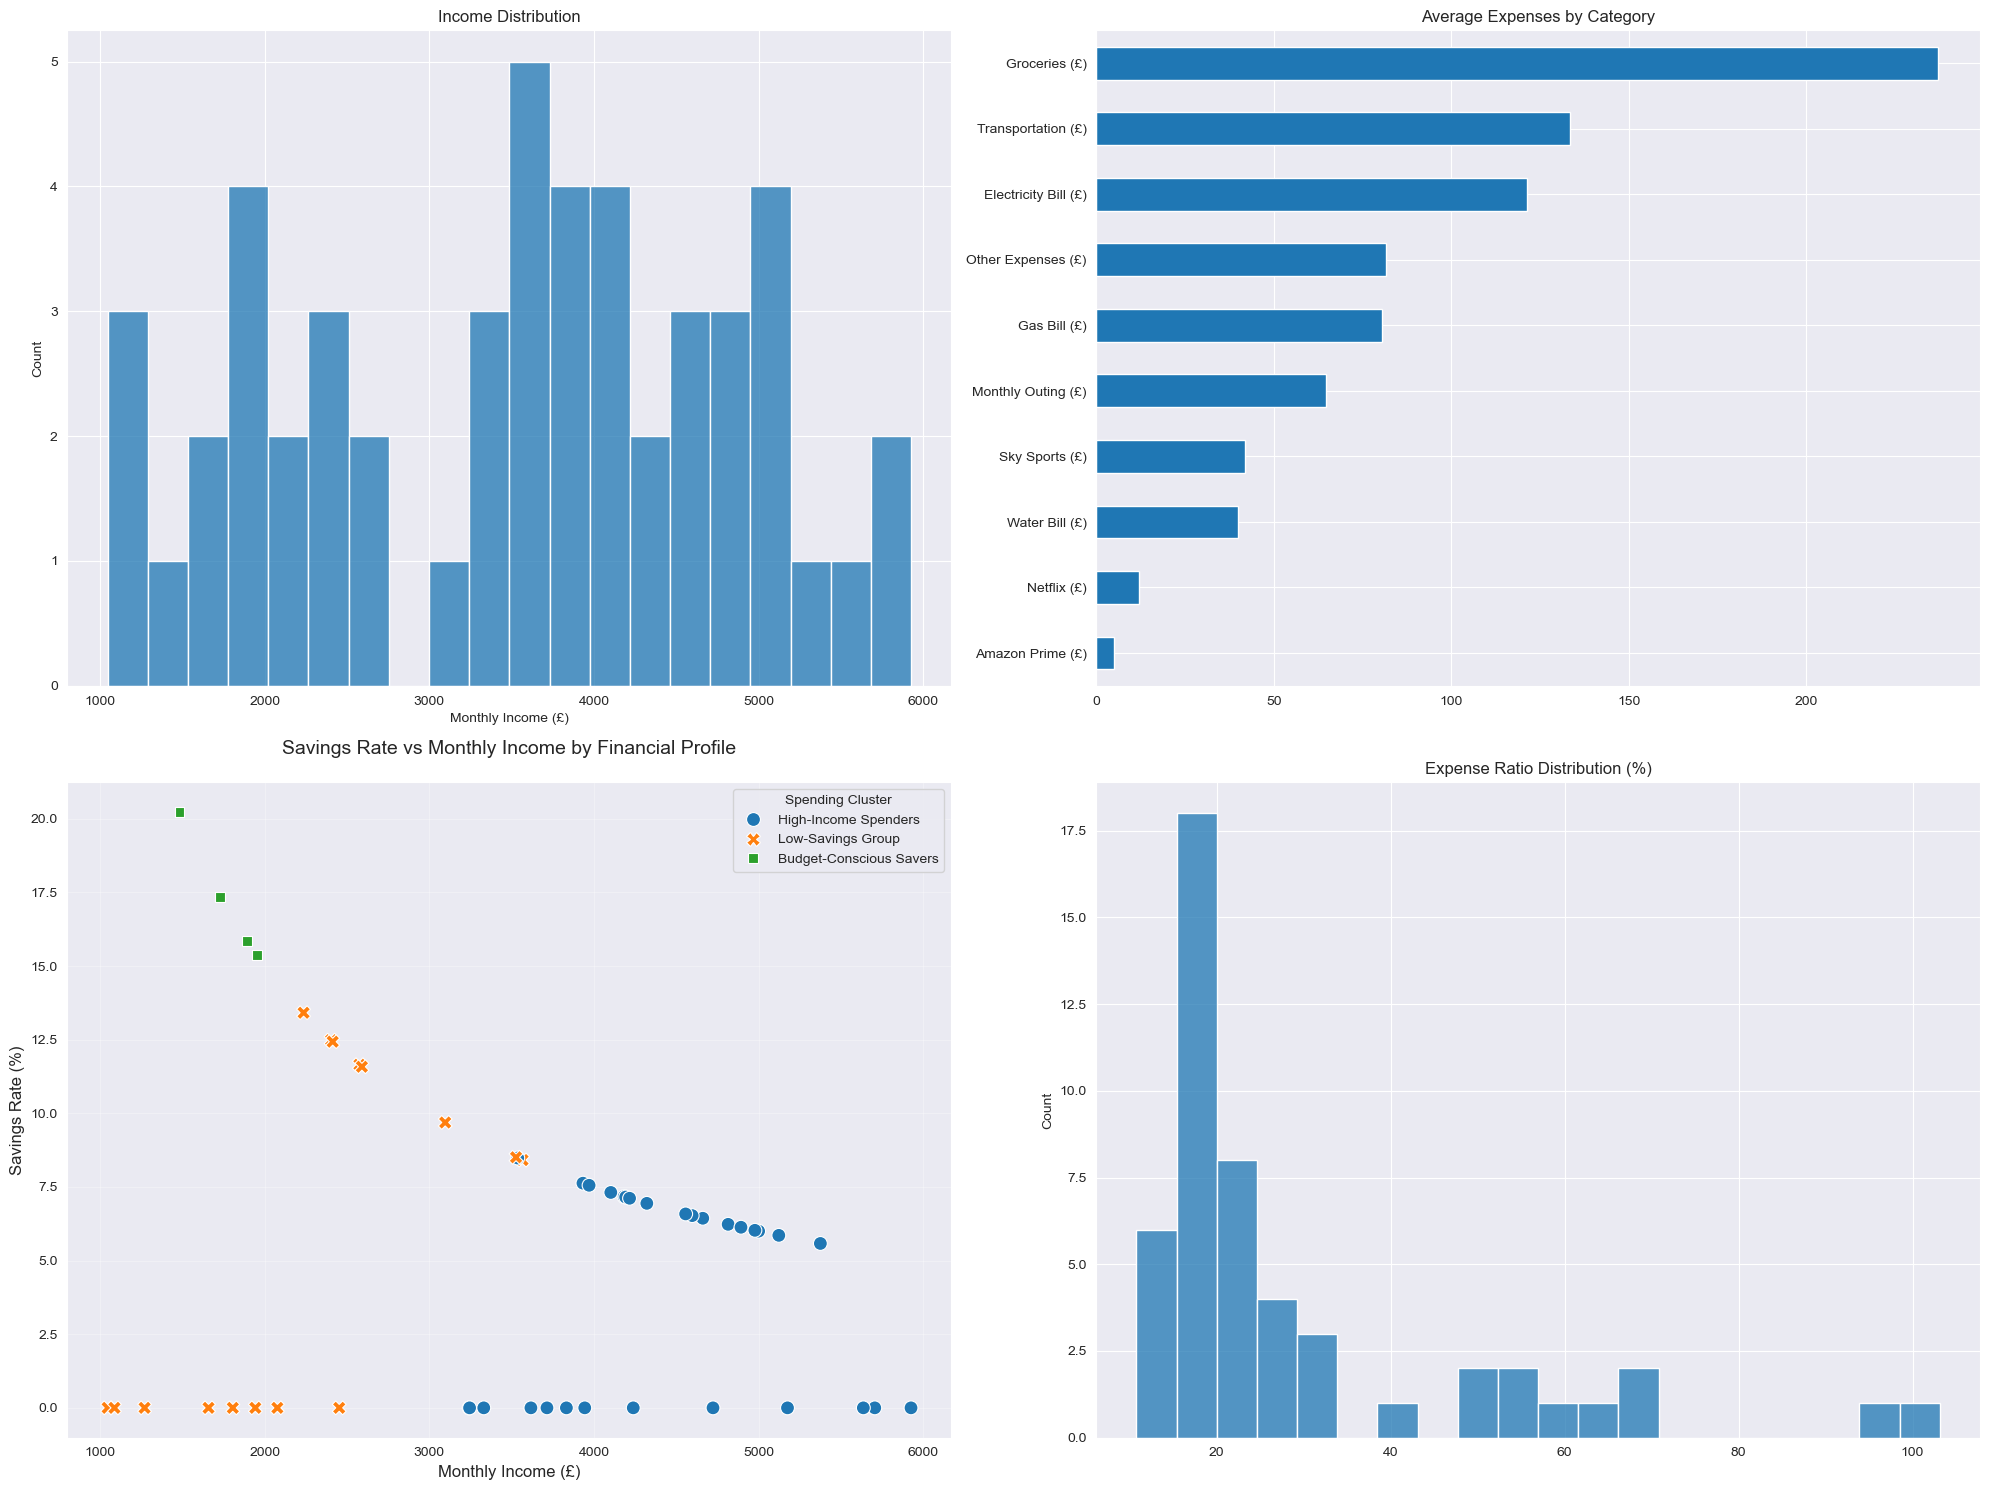

In [98]:
def create_visualizations(df):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Income Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Monthly Income (£)', bins=20)
    plt.title('Income Distribution')
    
    # 2. Expenses by Category
    plt.subplot(2, 2, 2)
    expense_columns = [col for col in df.columns if '(£)' in col and col not in ['Monthly Income (£)', 'Savings for Property (£)']]
    expenses_mean = df[expense_columns].mean().sort_values(ascending=True)
    expenses_mean.plot(kind='barh')
    plt.title('Average Expenses by Category')
    
    # 3. Savings Rate vs Income
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=df, x='Monthly Income (£)', y='Savings Rate', hue='Spending Cluster', s=100, style='Spending Cluster')
    plt.title('Savings Rate vs Monthly Income by Financial Profile', pad=20, size=14)
    plt.xlabel('Monthly Income (£)', size=12)
    plt.ylabel('Savings Rate (%)', size=12)
    # Add a grid for better readability
    plt.grid(True, alpha=0.3)
    
    # 4. Expense Ratio Analysis
    plt.subplot(2, 2, 4)
    expense_ratio = (df['Total Expenses'] / df['Monthly Income (£)']) * 100
    sns.histplot(expense_ratio, bins=20)
    plt.title('Expense Ratio Distribution (%)')
    
    plt.tight_layout()
    return fig

fig = create_visualizations(df)

**Scatterplot**
- Left to right (X-axis): How much money people make per month (£1000 to £6000)
- Bottom to top (Y-axis): How much they save as a percentage (0% to 20%)
- Each dot/square/X represents one person

**The Three Groups (like three types of shoppers):**

1. **Green Squares (Budget-Conscious Savers)**
   - These are like the super-savers at the store
   - They don't make tons of money (left side of graph)
   - BUT they save a lot (high up on graph)
   - Like someone who makes £2000 but saves 15-20% of it

2. **Orange X's (Low-Savings Group)**
   - These are like the occasional savers
   - They're spread out in how much they make
   - Most either save nothing (at the bottom) or save a medium amount
   - Like someone who makes £3000 but only saves 10% or nothing at all

3. **Blue Dots (High-Income Spenders)**
   - These are like the big earners who like to spend
   - They make lots of money (right side of graph)
   - But they don't save as much as you'd expect
   - Like someone who makes £5000 but only saves 5-8%

**The Big Picture:**
- Surprisingly, the people who save the most aren't the ones who make the most money
- There's a bunch of people (at the bottom) who don't save at all
- The more money people make (moving right), they tend to save less (moving down)


### Calculate Correlation Matrix

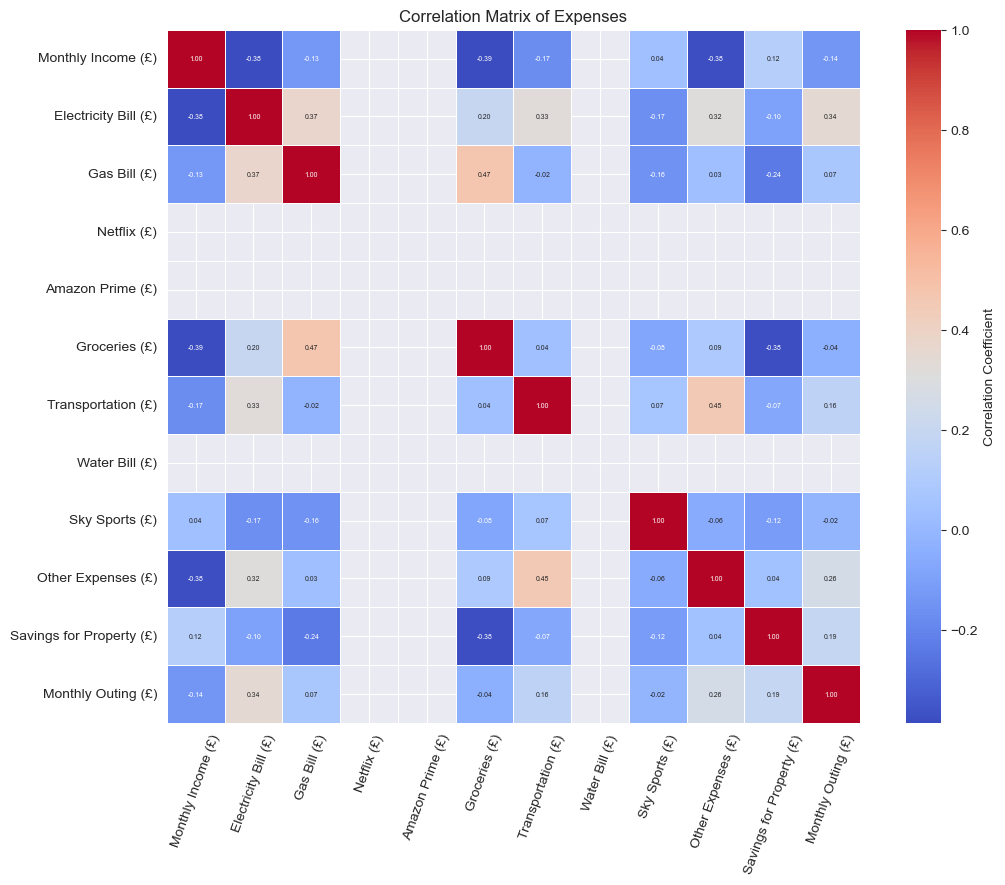

In [99]:
def calculate_correlation_matrix(df):
    #Categories of expenses
    expense_columns = [col for col in df.columns if '(£)' in col and col not in ['Employee']]

    # Calculate the correlation matrix
    correlation_matrix = df[expense_columns].corr()
    
    # Create a heatmap
    plt.figure(figsize=(12, 9))
    sns.heatmap(correlation_matrix, 
                annot=True, cmap='coolwarm', 
                fmt=".2f", 
                annot_kws={'size': 5}, 
                square=True,  
                linewidth=0.7, 
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix of Expenses')
    plt.xticks(rotation=70)
    plt.yticks(rotation=0)
    plt.show()
    
correlation_matrix = calculate_correlation_matrix(df)

**How to Read This:**
- Numbers range from -1 to 1
- Red = Positive correlation (when one goes up, the other goes up)
- Blue = Negative correlation (when one goes up, the other goes down)
- Darker color = Stronger relationship
- Numbers close to 0 = Almost no relationship

**Key Findings:**

1. **Strongest Positive Relationships:**
   - Gas Bill & Groceries (0.47): If someone has high gas bills, they tend to have high grocery expenses
   - Transportation & Other Expenses (0.45): People who spend more on transport also tend to have higher other expenses
   - Gas Bill & Electricity Bill (0.37): Utility bills tend to move together

2. **Strongest Negative Relationships:**
   - Monthly Income & Groceries (-0.39): Interestingly, higher earners tend to spend less on groceries
   - Monthly Income & Electricity Bill (-0.38): Higher earners also tend to have lower electricity bills
   - Monthly Income & Other Expenses (-0.38): Higher earners tend to have lower miscellaneous expenses

3. **Interesting Patterns:**
   - Savings has weak relationships with most expenses (mostly small numbers)
   - Netflix and Amazon Prime have missing correlations (blank spaces) as they're fixed costs
   - Monthly Outing doesn't strongly correlate with income (-0.14)

4. **Surprising Findings:**
   - Higher income doesn't mean higher savings (only 0.12 correlation)
   - Transportation and groceries barely correlate (0.04)
   - Sky Sports has very weak relationships with most other expenses

**Practical Meaning:**
1. Higher earners tend to:
   - Spend less on utilities
   - Spend less on groceries
   - Not necessarily save more

2. People who spend more on:
   - Gas also spend more on groceries
   - Transportation also have higher other expenses
   - Utilities tend to have higher bills across all utilities

In [100]:
df.head()

,Employee,Monthly Income (£),Electricity Bill (£),Gas Bill (£),Netflix (£),Amazon Prime (£),Groceries (£),Transportation (£),Water Bill (£),Sky Sports (£),Other Expenses (£),Savings for Property (£),Monthly Outing (£),Total Expenses,Savings Rate,Disposable Income,Spending Cluster
0,Employee_1,4999.39,120.000000,80.0000,12.0,4.99,239.69000,149.11000,40.0,70.0,100.000000,300.0,120.0,935.790000,6.000732,4063.600000,High-Income Spenders
1,Employee_2,4660.24,120.000000,80.0000,12.0,4.99,226.24000,197.23000,40.0,70.0,100.000000,300.0,120.0,970.460000,6.437437,3689.780000,High-Income Spenders
2,Employee_3,1942.89,124.679456,98.1346,12.0,4.99,333.77745,201.27956,40.0,70.0,125.770693,0.0,120.0,1130.631758,0.000000,812.258242,Low-Savings Group
3,Employee_4,3565.80,120.000000,80.0000,12.0,4.99,213.04000,154.67000,40.0,0.0,100.000000,300.0,120.0,844.700000,8.413259,2721.100000,Low-Savings Group
4,Employee_5,5121.99,120.000000,80.0000,12.0,4.99,182.56000,190.71000,40.0,70.0,100.000000,300.0,0.0,800.260000,5.857099,4321.730000,High-Income Spenders


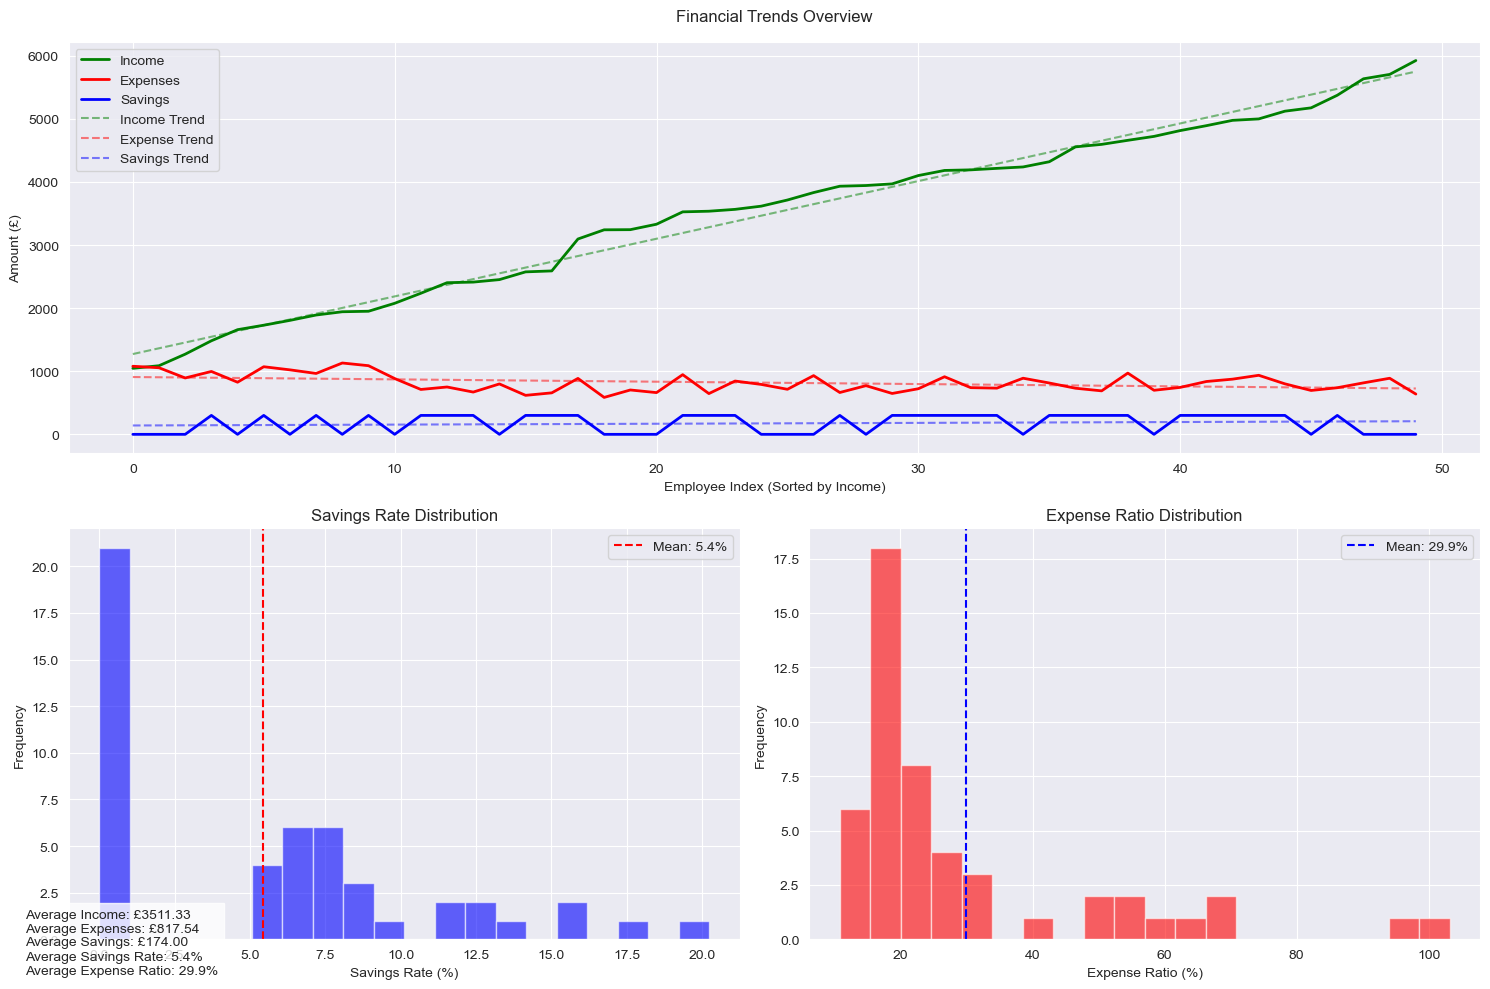

In [108]:
from matplotlib.gridspec import GridSpec

def create_trend_visualization():
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, figure=fig)
    
    expenses = df['Total Expenses']
    savings = df['Savings for Property (£)']
    income = df['Monthly Income (£)']
    
    # Sort data by income for trend visualization
    sorted_indices = np.argsort(income)
    sorted_income = income.iloc[sorted_indices]
    sorted_expenses = expenses.iloc[sorted_indices]
    sorted_savings = savings.iloc[sorted_indices]
    
    # 1. Income vs Expenses Trend
    ax1 = fig.add_subplot(gs[0, :])
    x = range(len(sorted_income))
    
    # Plot data
    ax1.plot(x, sorted_income, 'g-', label='Income', linewidth=2)
    ax1.plot(x, sorted_expenses, 'r-', label='Expenses', linewidth=2)
    ax1.plot(x, sorted_savings, 'b-', label='Savings', linewidth=2)
    
    # Add trend lines
    z_income = np.polyfit(x, sorted_income, 1)
    p_income = np.poly1d(z_income)
    ax1.plot(x, p_income(x), 'g--', alpha=0.5, label='Income Trend')
    
    z_expenses = np.polyfit(x, sorted_expenses, 1)
    p_expenses = np.poly1d(z_expenses)
    ax1.plot(x, p_expenses(x), 'r--', alpha=0.5, label='Expense Trend')
    
    z_savings = np.polyfit(x, sorted_savings, 1)
    p_savings = np.poly1d(z_savings)
    ax1.plot(x, p_savings(x), 'b--', alpha=0.5, label='Savings Trend')
    
    ax1.set_title('Financial Trends Overview', fontsize=12, pad=15)
    ax1.set_xlabel('Employee Index (Sorted by Income)', fontsize=10)
    ax1.set_ylabel('Amount (£)', fontsize=10)
    ax1.legend()
    
    # 2. Savings Rate Distribution
    ax2 = fig.add_subplot(gs[1, 0])
    savings_rate = (savings / income) * 100
    
    ax2.hist(savings_rate, bins=20, color='blue', alpha=0.6)
    ax2.axvline(savings_rate.mean(), color='red', linestyle='--', 
                label=f'Mean: {savings_rate.mean():.1f}%')
    
    ax2.set_title('Savings Rate Distribution', fontsize=12)
    ax2.set_xlabel('Savings Rate (%)', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.legend()
    
    # 3. Expense Ratio Analysis
    ax3 = fig.add_subplot(gs[1, 1])
    expense_ratio = (expenses / income) * 100
    
    ax3.hist(expense_ratio, bins=20, color='red', alpha=0.6)
    ax3.axvline(expense_ratio.mean(), color='blue', linestyle='--',
                label=f'Mean: {expense_ratio.mean():.1f}%')
    
    ax3.set_title('Expense Ratio Distribution', fontsize=12)
    ax3.set_xlabel('Expense Ratio (%)', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.legend()
    
    # Add overall statistics textbox
    stats_text = (
        f'Average Income: £{income.mean():.2f}\n'
        f'Average Expenses: £{expenses.mean():.2f}\n'
        f'Average Savings: £{savings.mean():.2f}\n'
        f'Average Savings Rate: {savings_rate.mean():.1f}%\n'
        f'Average Expense Ratio: {expense_ratio.mean():.1f}%'
    )
    
    fig.text(0.02, 0.02, stats_text, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
create_trend_visualization()

**How to Read This Graph:**
- Green line: Income trends
- Red line: Expense patterns
- Blue line: Savings behavior
- Dotted lines: Show overall trends
- X-axis: Employees sorted by income
- Y-axis: Amount in pounds (£)

**Key Findings:**

1. **Income Patterns (Green):**
   - Clear upward trend from £1,000 to £6,000
   - Steady increase across employee index
   - Some minor fluctuations but generally consistent growth
   - Steeper increase after employee index 40

2. **Expense Patterns (Red):**
   - Relatively flat trend around £1,000
   - Much lower variation compared to income
   - Slight downward trend despite income increases
   - Most expenses stay between £800-£1,200

3. **Savings Behavior (Blue):**
   - Generally low and consistent around £300
   - Some fluctuation but minimal variation
   - No strong correlation with income increases
   - Many employees show zero or minimal savings

4. **Distribution Analysis (Bottom Graphs):**
   - Savings Rate Distribution (Left):
     * Most common rate around 5.4%
     * Highly skewed distribution
     * Many employees with low savings rates
   
   - Expense Ratio Distribution (Right):
     * Average expense ratio of 29.9%
     * Right-skewed distribution
     * Most employees between 20-40%

**Key Statistics:**
- Average Income: £3,511.33
- Average Expenses: £617.54
- Average Savings: £174.00
- Average Savings Rate: 5.4%
- Average Expense Ratio: 29.9%

**Notable Insights:**
1. Higher income doesn't necessarily lead to proportionally higher savings
2. Expenses remain relatively stable regardless of income level
3. Most employees maintain similar expense patterns despite income differences
4. There's potential for increased savings among higher-income employees



## Financial Assistant

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def train_model():
    features = ['Total Expenses', 'Savings Rate', 'Disposable Income']
    x = df[features]
    y = df['Monthly Income (£)']
    
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor()
    model.fit(train_x.values, train_y)
    
    train_score = model.score(train_x, train_y)
    test_score = model.score(test_x, test_y)
    
    # Prediction of Monthly Income
    prediction = model.predict(test_x)
    
    return train_score, test_score, prediction

model = train_model()